# Ensemble Xgb

## Import Package


In [1]:
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import xgboost as xgb

In [3]:
from utils.metrics import evaluate

## Const & Inputs

Here are all of the parameters to change for the run.


In [4]:

# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# Number of classes in the dataset
num_classes = 33

# options: (subset, fullset)
train_mode = 'fullset'

# Models for ensemble
models = [
    {
        'name': 'bit',
        'path': 'BiT-M-R50x1_batch256_lr0.0003_fullset_v2'
    }, 
    {
        'name': 'efficientnet',
        'path': 'fullset_224_crop70xy_correct_by_rule_efficientnetb3_transfer_trainable_epochs100_batchsize64_lr0.0005_reducelr_dropout40'
    }, 
    {
        'name': 'dcnnlh',
        'path': 'DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-hmConcat-270rotate-low-high-85'
        # DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-classWeight-hmConcat-270rotate-85
    }, 
    {
        'name': 'convnextlhbase',
        # 'path': 'convnextSmall-adamW-labelSmoothing-270rotate-low-high-85'
        'path': 'convnextBase-adamW-labelSmoothing-270rotate-low-high-85'
    }, 
]

submissions = [
    {
        'name': 'bitcrop',
        'path': 'BiT-M-R152x2_batch256_lr0.0003_fullset_crop_data2_oriSize_public_submission'
    }, 
    {
        'name': 'efficientnet',
        'path': 'fullset_224_crop70xy_correct_by_rule_efficientnetb3_transfer_trainable_epochs100_batchsize64_lr0.0005_reducelr_dropout40'
    }, 
    {
        'name': 'dcnnlh',
        # 'path': 'DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-classWeight-hmConcat-270rotate-85'
        'path': 'DCNN2-feature4-conv14-he_uniform-adam-labelSmoothing-hmConcat-270rotate-low-high-85'
    }, 
    {
        'name': 'convnextlhbase',
        # 'path': 'convnextSmall-adamW-labelSmoothing-270rotate-low-high-85'
        'path': 'convnextBase-adamW-labelSmoothing-270rotate-low-high-85'
    }, 
]


In [5]:
tw = ["非作物", "甘藍", "甘藷", "檳榔", "芒果", "竹筍", "茶", "蔥", "木瓜", "太陽麻", "紅豆", "毛豆", "芋", "葡萄", "青花菜", "茭白筍", "絲瓜",
      "荔枝", "龍眼", "韭菜", "狼尾草", "檸檬", "萵苣", "花椰菜", "梨", "田菁", "番荔枝", "百香果", "蓮霧", "結球白菜", "溫網室", "洋蔥", "蘆筍"]
en = ["others", "kale", "sweetpotato", "betel", "mango", "bambooshoots", "tea", "greenonion", "papaya", "sunhemp", "redbeans", "soybeans", "taro", "grape", "broccoli", "waterbamboo", "loofah", "litchi",
      "longan", "chinesechives", "pennisetum", "lemon", "lettuce", "cauliflower", "pear", "sesbania", "custardapple", "passionfruit", "roseapple", "chinesecabbage", "greenhouse", "onion", "asparagus"]
classes_name = pd.DataFrame({"tw": tw, "en": en}).sort_values(by=['en'], ignore_index=True)

## Helper

In [6]:
def apply_inductive_rules(label, county_name, town_name, full_rules, threshold=1):
    inductive_label = ""
    rules = full_rules.copy()
    rules = rules[rules['label_percentage_in_town'] >= threshold].reset_index(drop=True)
    for i, rule in rules.iterrows():
        if(rule['county_name'] == county_name and rule['town_name'] == town_name):
            inductive_label = rule['label']
    return inductive_label if inductive_label else label

In [7]:
def apply_exclusion_rules(label_prob, county_name, town_name, full_rules, threshold=0.0):
    exclusion_prob = label_prob.copy()
    rules = full_rules.copy()
    rules = rules[rules['county_name'].eq(county_name) & rules['town_name'].eq(town_name)].sort_values(by=['label'], ascending=True, ignore_index=True)
    rules = rules[rules['town_percentage_in_label'] <= threshold]
    excluded_indices = rules.index.tolist()
    exclusion_prob[excluded_indices] = 0
    return exclusion_prob

## Data Preprocessing

### Load Data

Load the prediction results of 3 models and merge into a DataFrame.

In [8]:
data = pd.read_pickle(F'{path}/data/train_split_{train_mode}.pkl').sort_values(by=['file']).reset_index(drop=True)

In [9]:
# Copy result from each model
for i in range(len(models)):
    print(models[i]['name'])
    result = pd.read_pickle(F'{path}/outputs/train/{models[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    data[f'predict_{models[i]["name"]}'] = result['predict']
    data[f'predict_label_{models[i]["name"]}'] = result['predict_label']

bit
efficientnet
dcnnlh
convnextlhbase


### Encode categorical features

OneHotEncoder or LabelEncoder.


In [10]:
from sklearn.preprocessing import LabelEncoder
# Class for label
labelenc = LabelEncoder()
labelenc.fit(data['label'].values)
data['class'] = labelenc.transform(data['label'].values)

### Split Data & Evaluate

Split data into train, validation and test sets.


In [11]:
train = data[data['set_name'].eq('train') | data['set_name'].eq('test')].reset_index(drop=True)
valid = data[data['set_name'].eq('valid')].reset_index(drop=True)
# Generate test from valid(8:2)
valid['test_in_valid'] = np.nan
valid.groupby(['label', 'county_name']).apply(lambda x: valid["test_in_valid"].fillna(pd.Series(data=1, index=x.sample(frac=0.20, random_state=5397).index), inplace=True))
test = valid[valid['test_in_valid'].eq(1)].reset_index(drop=True)
valid = valid[~valid['test_in_valid'].eq(1)].reset_index(drop=True)
print(F"data: {data.shape}, train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

data: (89514, 30), train: (76124, 30), valid: (10727, 31), test: (2663, 31)


In [12]:
# Evaluate each model on train
print('train')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(train['label'].tolist(), train[f'predict_label_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

train
bit 0.9483
efficientnet 0.9265
dcnnlh 0.9991
convnextlhbase 0.9994


In [13]:
# Evaluate each model on valid
print('valid')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(valid['label'].tolist(), valid[f'predict_label_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

valid
bit 0.8751
efficientnet 0.7603
dcnnlh 0.7659
convnextlhbase 0.8619


## Classification Prediction
Based on the output of each model.

In [19]:
def initialize_model(params, num_classes):
    # Initialize these variables which will be set in this if statement, each of these variables is model specific.
    model_ft = None
    model_ft = xgb.XGBClassifier(**params)
    return model_ft

In [20]:
def build_x_y(df, models, list_of_use_models, num_classes=num_classes):
    # Build inputs of prob from each model
    x = np.concatenate([
        np.array(df[f'predict_{models[i]["name"]}'].tolist()).reshape(-1, num_classes) for i in list_of_use_models
    ], axis=1)
    # Add doy & camera
    x = np.concatenate([
        x,
        # df['town_x'].values.reshape(-1, 1),
        # df['town_y'].values.reshape(-1, 1),
        # df['town_z'].values.reshape(-1, 1),
    ], axis=1)
    y = np.array(df['class'].tolist())
    return x, y

In [23]:
list_of_use_models = [i for i in range(len(models))]

# Print the new model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

# Build x, y for model
x_valid, y_valid = build_x_y(valid, models, list_of_use_models)
x_test, y_test = build_x_y(test, models, list_of_use_models)

# best_params = read_pkl(f'./models/vit-eff6-dcnn(doy-sig)-dcnn(doy)-Hyperopt1000.pkl')
best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0, 'n_estimators': 500}

# Create model & train
clf = initialize_model(best_params, num_classes)
clf.fit(x_valid, y_valid)

bit-efficientnet-dcnnlh-convnextlhbase


In [24]:
# Predict the response for test dataset
y_pred = clf.predict(x_test)

# Save the best model
# clf.save_model(F"{path}/models/ensemble-xgb-{model_set}.json")

# Transform the encoded predictions to their actual values
y_test_inverse = labelenc.inverse_transform(y_test)
y_pred_inverse = labelenc.inverse_transform(y_pred)

# Evaluate the model
evaluation = evaluate(y_test_inverse.tolist(), y_pred_inverse.tolist())
print(round(pd.DataFrame(evaluation).T['precision']['weighted avg'], 6))  
# 0.900958  

0.900958


In [35]:
# 3 models
# 0.889204
# 3 models + town_z
# 0.889119
# 3 models + town_x + town_y + town_z
# 0.887062
# 4 models: 0.894367
# 4 models + town_z: 0.891296
# 4 models(conv-next-base): 0.894367


#### Hyperparameter Optimization
2 & 5

In [25]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.iteration = 0
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo,
                          max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return {'result': result, 'history': trials}

    def xgb_clf(self, para):
        clf = xgb.XGBClassifier(**para['clf_params'])
        return self.train_clf(clf, para)

    def train_clf(self, clf, para):
        self.iteration += 1
        time_start = time.time()
        clf.fit(
            self.x_train, self.y_train,
            **para['fit_params']
        )
        pred = clf.predict(self.x_test)
        time_end = time.time()
        run_time = time_end - time_start

        loss = para['loss_func'](self.y_test, pred)
        return {'iteration': self.iteration, 'loss': loss, 'train_time': run_time, 'params': para, 'status': STATUS_OK}

default setting

```python
{
    'objective':        'multi:softproba',   
    'num_class':        num_classes,
    'tree_method':      'gpu_hist', 
    'gpu_id':           0,
    'eval_metric':      'auc',
    'booster':          'gbtree',
    'n_estimators':     scope.int(hp.quniform('n_estimators', 200, 1500, 100)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'gamma':            hp.uniform ('gamma', 0.0, 10.0), # min_split_loss
    'max_depth':        scope.int(hp.quniform('max_depth', 1, 20, 2)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'max_delta_step':   hp.quniform('max_delta_step', 0, 20, 2),
    'subsample':        hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha':        hp.uniform('reg_alpha', 0.1, 1.0),  # L1 regularization
    'reg_lambda':       hp.uniform('reg_lambda', 0.0, 1.0), # L2 regularization
}
```

In [26]:

from hyperopt.pyll.base import scope
# from hyperopt.pyll.stochastic import sample
# sample(scope.int(hp.quniform('example', 0, 10, 1)))
# Returns an integer from 0 to 10, inclusive

xgb_para = dict()
xgb_para['clf_params'] = {
    'objective':        'multi:softproba',   
    'num_class':        num_classes,
    'tree_method':      'gpu_hist', 
    'gpu_id':           0,
    'eval_metric':      'auc',
    'booster':          'gbtree',
    'n_estimators':     scope.int(hp.quniform('n_estimators', 200, 1500, 100)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'gamma':            hp.uniform ('gamma', 0.0, 10.0), # min_split_loss
    'max_depth':        scope.int(hp.quniform('max_depth', 1, 20, 2)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'max_delta_step':   hp.quniform('max_delta_step', 0, 20, 2),
    'subsample':        hp.quniform('subsample', 0.1, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.1),
    'reg_alpha':        hp.uniform('reg_alpha', 0.1, 1.0),  # L1 regularization
    'reg_lambda':       hp.uniform('reg_lambda', 0.0, 1.0), # L2 regularization
}
xgb_para['fit_params'] = {}
xgb_para['loss_func'] = lambda y, pred: -evaluate(y.tolist(), pred.tolist())['weighted avg']['f1-score']

In [27]:
iteration = 1000

# Obtain all models index
list_of_use_models = [i for i in range(len(models))]
    
# Print model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

# Build x, y for model
x_valid, y_valid = build_x_y(valid, models, list_of_use_models)
x_test, y_test = build_x_y(test, models, list_of_use_models)
    
# Init
obj = HPOpt(x_valid, x_test, y_valid, y_test)

# Run optimization
trials = Trials()
opt = obj.process(fn_name='xgb_clf', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=iteration)

# Show best params 
history = pd.DataFrame(opt['history'].results)
best_params = history.loc[history['loss'].idxmin()]['params']['clf_params']

# (cpu)opt x2 = 19:56
# (gpu)opt x2 = 07:29, 1 = 4:30
# (gpu)opt x10 = 50:10, 1 = 5:00

# Save best params
# save dict to json
with open(F'{path}/models/ensemble-xgb-{model_set}-xyz-hyperopt{iteration}-params.json', 'w') as f:
    json.dump(best_params, f)
history.to_csv(F'{path}/logs/ensemble-xgb-{model_set}-xyz-hyperopt{iteration}.csv')

# Drow loss
plt.plot(history['loss'])

bit-efficientnet-dcnnlh-convnextlhbase
  0%|          | 3/1000 [01:55<10:30:33, 37.95s/trial, best loss: -0.9008078211734569]

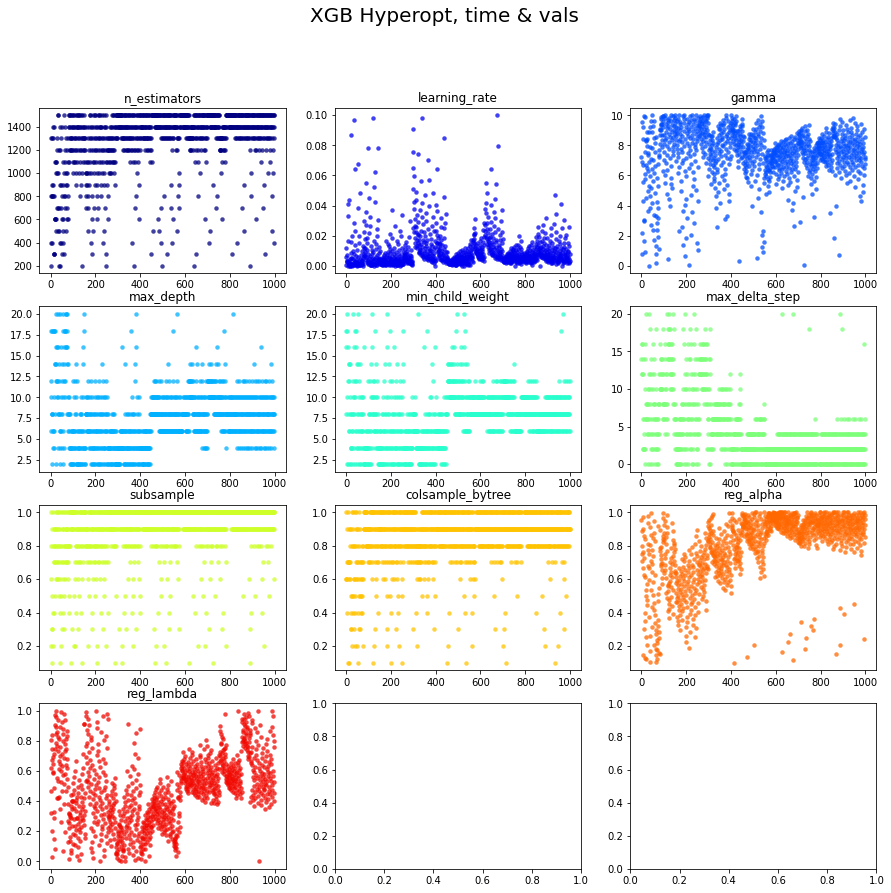

In [ ]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, time & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['tid'] for t in trials.trials]).ravel()
    ys = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

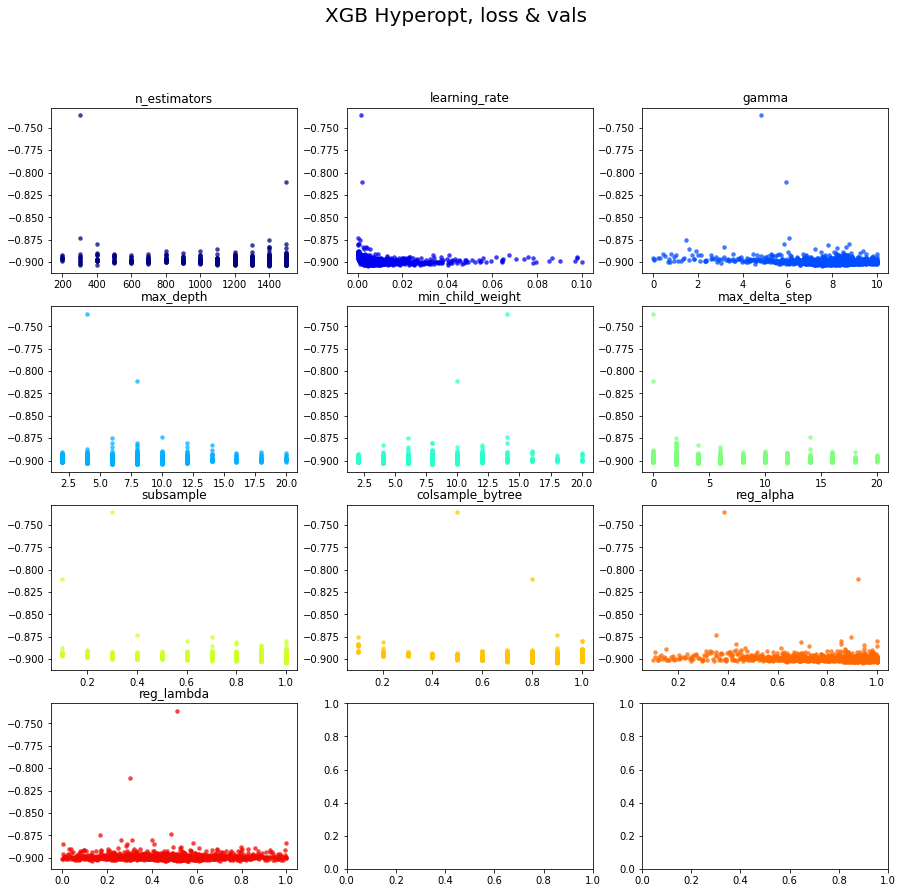

In [ ]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, loss & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

### Save Results


In [15]:
# label_percentage_in_town => inductive_threshold will apply rules
inductive_threshold = 1.0

# town_percentage_in_label <= exclusion_threshold will apply rules
exclusion_threshold = 0.0

# analysis
train_label_town_percentage = pd.read_csv(F'{path}/analysis/train_label_town_percentage.csv')
train_label_town_percentage.head(3)

,label,county_name,town_name,counts,town_percentage_in_label,label_percentage_in_town
0,asparagus,彰化縣,二林鎮,898.0,0.43998,0.222829
1,asparagus,新竹市,東區,5.0,0.00245,0.025641
2,asparagus,屏東縣,枋寮鄉,0.0,0.00000,0.000000


In [16]:
# Read basic information of dataset
submission = pd.read_csv(f'{path}/data/public_tag_loc_coor_describe_elevation.csv').sort_values(by=['file']).reset_index(drop=True)
submission = submission.rename(columns={'file': 'filename'})
submission['class'] = np.nan
submission.columns

Index(['filename', 'height', 'width', 'taken_datetime', 'make', 'model',
       'target_fid', 'target_x', 'target_y', 'county_name', 'town_name',
       'town_x', 'town_y', 'town_z', 'angle', 'class'],
      dtype='object')

In [17]:
# Copy result from each model
for i in range(len(submissions)):
    result = pd.read_pickle(F'{path}/outputs/public/{submissions[i]["path"]}.pkl').sort_values(by=['file']).reset_index(drop=True)
    submission[f'predict_{submissions[i]["name"]}'] = result['predict']
    submission[f'predict_label_{submissions[i]["name"]}'] = result['predict_label']

In [18]:
# ['XGBoost', 'LightGBM']
model_name = 'XGBoost'

# Build model set
list_of_use_models = [i for i in range(len(submissions))]

# Print model set
model_set = '-'.join([submissions[i]["name"] for i in list_of_use_models])
print(model_set)

bitcrop-efficientnet-dcnnlh-convnextlhbase


In [122]:
# Build x, y for model
x_submission, y_submission = build_x_y(submission, submissions, list_of_use_models)

# best_params = read_pkl(f'./models/vit-eff6-dcnn(doy-sig)-dcnn(doy)-Hyperopt500(camera).pkl')
# best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0}

# Create the model [LightGBM, XGBoost]
clf = initialize_model({}, num_classes)
# clf.fit(x_valid, y_valid)
# clf.save_model(F"{path}/models/ensemble-xgb-{model_set}-xyz-hyperopt-{iteration}.json")

# load model
clf.load_model(F"{path}/models/ensemble-xgb-bitcrop-efficientnet-dcnnlh-convnextlh-hyperopt1000.json")

In [123]:
# Predict the response for test dataset
submission['proba'] = list(clf.predict_proba(x_submission))

# Apply Exclusion Rules
submission['proba_exclusion'] = submission.apply(lambda row: apply_exclusion_rules(row['proba'], row['county_name'], row['town_name'], train_label_town_percentage, exclusion_threshold), axis=1)

# Inverse Transform
submission['label'] = submission['proba'].apply(lambda x: np.argmax(x))
submission['label_exclusion'] = submission['proba_exclusion'].apply(lambda x: np.argmax(x))
submission['label'] = labelenc.inverse_transform(submission['label'])
submission['label_exclusion'] = labelenc.inverse_transform(submission['label_exclusion'])
print('exclusion counts:', len(submission[submission['label'] != submission['label_exclusion']]))

# 0.0 = 73

exclusion counts: 73


In [131]:
# Apply Inductive Rules
submission['label_inductive'] = submission.apply(lambda row: apply_inductive_rules(row['label'], row['county_name'], row['town_name'], train_label_town_percentage, inductive_threshold), axis=1)
submission['label_exclusion_inductive'] = submission.apply(lambda row: apply_inductive_rules(row['label_exclusion'], row['county_name'], row['town_name'], train_label_town_percentage, inductive_threshold), axis=1)
print('inductive counts:', len(submission[submission['label'] != submission['label_inductive']]))
print('inductive exclusion counts:', len(submission[submission['label_exclusion'] != submission['label_exclusion_inductive']]))

# 0.90 = 10
# 0.91 = 10
# 0.92 = 1

inductive counts: 0
inductive counts: 0


In [83]:
# train_label_town_percentage[train_label_town_percentage['county_name'].eq('新竹縣') & train_label_town_percentage['town_name'].eq('新埔鎮')]

In [130]:
# File rename
# submission[['filename', 'label_inductive']].rename(columns={'label_inductive': 'label'}).to_csv(F'{path}/submission/public/xgb-{model_set}-hyperopt{1000}-bitcrop-convnextbase-inductive-{int(inductive_threshold * 100)}.csv', index=False)    
# submission[['filename', 'label_exclusion']].rename(columns={'label_exclusion': 'label'}).to_csv(F'{path}/submission/public/xgb-{model_set}-hyperopt{1000}-bitcrop-convnextbase-exclusion-{int(exclusion_threshold * 100)}.csv', index=False)    
# submission[['filename', 'label']].to_csv(F'{path}/submission/public/xgb-{model_set}-hyperopt{1000}-bitcrop-convnextbase.csv', index=False)    